In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')

In [3]:
cleaned_KC.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.677350
grade            0.668031
sqft_living15    0.593302
bathrooms        0.488813
view             0.387338
bedrooms         0.301746
floors           0.257418
sqft_lot         0.083969
sqft_lot15       0.077855
yr_built         0.046841
condition        0.045438
id              -0.015326
zipcode         -0.046692
Name: price, dtype: float64

Sqft_living and sqft_living15 are thought to have multi-collinearity, thus we will drop sqft_living15

In [4]:
categorical_features = ['bathrooms','bedrooms','zipcode','yr_built','grade','condition','view','floors']

In [5]:
# converts all categorical features to a categorical type
for feature in categorical_features:
    cleaned_KC[feature] = cleaned_KC[feature].astype('category')
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21347
Data columns (total 15 columns):
id               21301 non-null int64
date             21301 non-null object
price            21301 non-null float64
bedrooms         21301 non-null category
bathrooms        21301 non-null category
sqft_living      21301 non-null int64
sqft_lot         21301 non-null int64
floors           21301 non-null category
view             21301 non-null category
condition        21301 non-null category
grade            21301 non-null category
yr_built         21301 non-null category
zipcode          21301 non-null category
sqft_living15    21301 non-null int64
sqft_lot15       21301 non-null int64
dtypes: category(8), float64(1), int64(5), object(1)
memory usage: 1.5+ MB


In [6]:
# select only columns with datatype int64 or float 64
numeric_cleaned_KC = cleaned_KC.select_dtypes(include=['int64','float64'])

# then drop the sqft_living15 and id column to reduce noise.
numeric_cleaned_KC = numeric_cleaned_KC.drop(axis=1, columns=['sqft_living15', 'id'])

vif = pd.DataFrame()
# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Factor"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# simply label the scores with their related columns
vif["features"] = numeric_cleaned_KC.columns

vif.round(1)

,VIF Factor,features
0,6.6,price
1,7.0,sqft_living
2,2.3,sqft_lot
3,2.5,sqft_lot15


sqft_living has a positive correlation with price
bathrooms has a positive correlation with price
sqft_living15 has a positive correlation with price

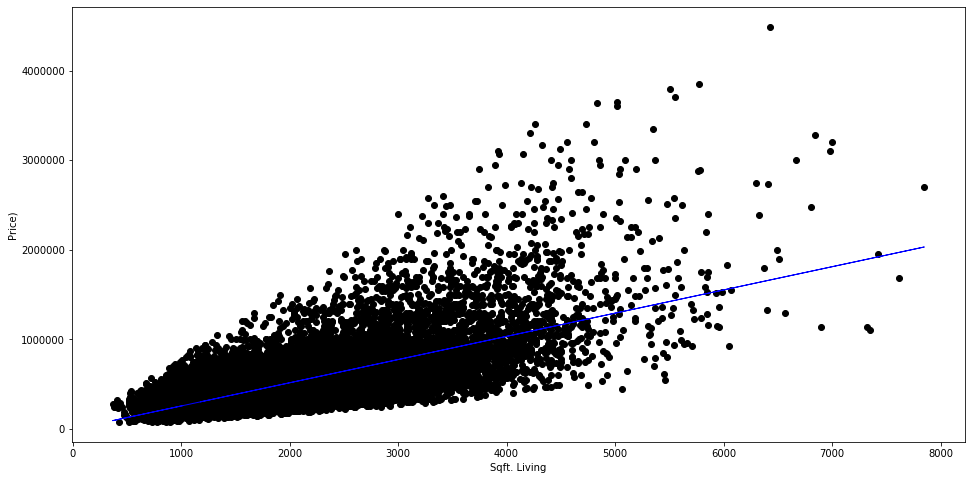

In [7]:
# What does .reshape do?
X = cleaned_KC['sqft_living'].values.reshape(-1,1)
y = cleaned_KC['price'].values.reshape(-1,1)

# Create a Linear Regression object and fit a line using X and y
reg = LinearRegression()
reg.fit(X, y)

# using that line, make predictions for y using X
predictions = reg.predict(X)

# Make a 16x8 figure that has...
plt.figure(figsize=(16, 8))

# ...a scatter plot of sqft_living vs price...
plt.scatter(
    cleaned_KC['sqft_living'],
    cleaned_KC['price'],
    c='black'
)

# ...plot the regression line...
plt.plot(
    cleaned_KC['sqft_living'],
    predictions,
    c='blue',
    linewidth=1
)

# ...set the labels and show
plt.xlabel("Sqft. Living")
plt.ylabel("Price)")
plt.show()

Here we run a Linear Regression on Price vs Sqft_living

In [8]:
X = cleaned_KC['sqft_living']
y = cleaned_KC['price']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:50:00   Log-Likelihood:            -2.9433e+05
No. Observations:               21301   AIC:                         5.887e+05
Df Residuals:                   21299   BIC:                         5.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2283.2967   4289.244     -0.532      

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Here we run a Multiple Linear Regression on Price vs Sqft_living, Bedrooms, Bathrooms, Yr_built, Zipcode, grade, condition, view, floors

In [9]:
col = categorical_features
col.insert(0,'sqft_living')
X = np.column_stack((cleaned_KC[x] for x in col))
y = cleaned_KC['price']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
col.insert(0,'price')
print(est.summary(xname=col))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3996.
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:50:02   Log-Likelihood:            -2.9033e+05
No. Observations:               21301   AIC:                         5.807e+05
Df Residuals:                   21291   BIC:                         5.808e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
price        8.165e+06   2.83e+06      2.886      

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Previous R-squared & Adj. R-Squared = .52
New R-square value = .628

Here we attepy to run Train/Test split

In [10]:
categorial_columns = ['bathrooms','bedrooms','grade','view','floors']
non_categorial_columns = ['id','date','price','sqft_lot','condition','yr_built','zipcode','sqft_living15', 'sqft_lot15']

# This replaces categorical columns with dummy variables, and drops non categorical columns
dummies_df = pd.get_dummies(cleaned_KC, columns=categorial_columns).drop(columns=non_categorial_columns)

In [11]:
# This sets X to a dataframe consisting of columns with dummy variables & without extra columns.
X = dummies_df

# this simply sets y to the price column of the dataframe
y = cleaned_KC['price']

# This runs a train/test split with .20 of the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [12]:
# Simply adding a y-intercept column.
X2 = sm.add_constant(X_train)

# Using statsmodels, run an Ordinary Least Squares test using the array of y values, and the dataframe of x_test values and fit a line to it. 
est = sm.OLS(y_train, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     681.6
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:50:07   Log-Likelihood:            -2.3251e+05
No. Observations:               17040   AIC:                         4.651e+05
Df Residuals:                   16999   BIC:                         4.654e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.175e+05   1.82e+04     22.

In [13]:
# Creates a Linear Regression object
lin_reg = LinearRegression()

# Train the Regression object to fit a line with train data
lin_reg.fit(X_train, y_train)

# using that line, predict y values against x_test values.
y_pred = lin_reg.predict(X_test)

# Use sklearn.metrics.r2_score to determine r-squared based on y_test values and y_pred values.
r2_score(y_test, y_pred)

0.6237849298395934

In [14]:
mean_squared_error(y_test, y_pred)

41140945097.0874